### This code uses scikit-learn, a Python library for machine learning. ###
### Scikit-learn was developed by a large community of contributors and is released under a permissive open source license. ###
### For more information, see: https://scikit-learn.org/stable/ ###

In [1]:
#!pip install openml

In [2]:
import openml
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 25)
import time

import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode
init_notebook_mode(connected = True)
import plotly.express as px

from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay

In [3]:
start_time = time.time()

# Read dataset #

In [4]:
datasets_df = openml.datasets.list_datasets(output_format="dataframe")

In [5]:
r = [datasets_df.loc[lambda datasets_df: datasets_df['name'] == 'Titanic']]
r

[         did     name  version uploader  status format  MajorityClassSize  \
 40704  40704  Titanic        2      869  active   ARFF             1490.0   
 40945  40945  Titanic        1        2  active   ARFF              809.0   
 41265  41265  Titanic        4     5243  active   ARFF                NaN   
 42436  42436  Titanic        5    12282  active   arff                NaN   
 42438  42438  Titanic        7    12282  active   arff                NaN   
 
        MaxNominalAttDistinctValues  MinorityClassSize  NumberOfClasses  \
 40704                       2.0                 711.0              2.0   
 40945                       3.0                 500.0              2.0   
 41265                       NaN                   NaN              0.0   
 42436                       NaN                   NaN              0.0   
 42438                       NaN                   NaN              0.0   
 
        NumberOfFeatures  NumberOfInstances  \
 40704               4.0       

In [6]:
dataset = openml.datasets.get_dataset(40945)

# Print a description
print(
    f"This is dataset '{dataset.name}', the target feature is "
    f"'{dataset.default_target_attribute}'"
    f"URL: {dataset.url}"
)

print(dataset.description)

This is dataset 'Titanic', the target feature is 'survived'URL: https://api.openml.org/data/v1/download/16826755/Titanic.arff
**Author**: Frank E. Harrell Jr., Thomas Cason  
**Source**: [Vanderbilt Biostatistics](http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/titanic.html)  
**Please cite**:   

The original Titanic dataset, describing the survival status of individual passengers on the Titanic. The titanic data does not contain information from the crew, but it does contain actual ages of half of the passengers. The principal source for data about Titanic passengers is the Encyclopedia Titanica. The datasets used here were begun by a variety of researchers. One of the original sources is Eaton & Haas (1994) Titanic: Triumph and Tragedy, Patrick Stephens Ltd, which includes a passenger list created by many researchers and edited by Michael A. Findlay.

Thomas Cason of UVa has greatly updated and improved the titanic data frame using the Encyclopedia Titanica and created the d

In [7]:
X, y, categorical_indicator, attribute_names = dataset.get_data(
    dataset_format="dataframe", target=dataset.default_target_attribute
)

In [8]:
df = pd.DataFrame(X, columns=attribute_names)
df["survived"] = y
df.head(10)

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest,survived
0,1,"Allen, Miss. Elisabet...",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO",1
1,1,"Allison, Master. Huds...",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Cheste...",1
2,1,"Allison, Miss. Helen ...",female,2.0000,1,2,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Cheste...",0
3,1,"Allison, Mr. Hudson J...",male,30.0000,1,2,113781,151.5500,C22 C26,S,None,135.0,"Montreal, PQ / Cheste...",0
4,1,"Allison, Mrs. Hudson ...",female,25.0000,1,2,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Cheste...",0
5,1,"Anderson, Mr. Harry",male,48.0000,0,0,19952,26.5500,E12,S,3,NaN,"New York, NY",1
6,1,"Andrews, Miss. Kornel...",female,63.0000,1,0,13502,77.9583,D7,S,10,NaN,"Hudson, NY",1
7,1,"Andrews, Mr. Thomas Jr",male,39.0000,0,0,112050,0.0000,A36,S,None,NaN,"Belfast, NI",0
8,1,"Appleton, Mrs. Edward...",female,53.0000,2,0,11769,51.4792,C101,S,D,NaN,"Bayside, Queens, NY",1
9,1,"Artagaveytia, Mr. Ramon",male,71.0000,0,0,PC 17609,49.5042,None,C,None,22.0,"Montevideo, Uruguay",0


In [9]:
y= y.astype('float')

In [10]:
df.dtypes

pclass          uint8
name           object
sex          category
age           float64
sibsp           uint8
parch           uint8
ticket         object
fare          float64
cabin          object
embarked     category
boat           object
body          float64
home.dest      object
survived     category
dtype: object

In [11]:
df.dtypes.index

Index(['pclass', 'name', 'sex', 'age', 'sibsp', 'parch', 'ticket', 'fare',
       'cabin', 'embarked', 'boat', 'body', 'home.dest', 'survived'],
      dtype='object')

1. Survived is a flag that indicates if a passenger survived or died ( i.e., 0 = No, 1 = Yes).
2. Pclass is the passenger class (i.e., 1 = 1st class, 2 = 2nd class, 3 = 3rd class).
3. Name is the name of the passenger.
4. Sex indicates the gender of the passenger (i.e., Male or female).
5. Age indicates the age of the passenger.
6. Sibsp is the number of siblings/spouses aboard.
7. Parch is the number of parents/children aboard.
8. Ticket indicates the ticket number issued to the passenger.
9. Fare indicates the amount of money spent on their ticket.
10. Cabin indicates the cabin category occupied by the passenger.
11. Embarked indicates the port where the passenger embarked from (i.e., C = Cherbourg, Q = Queenstown, S = Southampton).
12. Boat indicates the identification of the lifeboat the passenger was on.
13. Body indicates the body identification number.
14. Home.dest indicates home/destination of the passenger. 

# Univariate analysis #
## Categorical variable ##

In [12]:
def plotFrequency(variable):
    absFreq = variable.value_counts()
    relFreq = variable.value_counts(normalize=True).round(4)*100
    df = pd.DataFrame({
        "absoluteFrequency":absFreq,
        "relativeFrequency":relFreq
    })
    fig=make_subplots(rows=1, cols=2, vertical_spacing=0.3, subplot_titles=("Absolute Frequency", "Relative Frequency"), print_grid=False)
    fig.add_trace(go.Bar(y=df.index, x=df.absoluteFrequency, orientation="h", text=df.absoluteFrequency, hoverinfo="x+y", textposition="auto", 
        name="Abs Freq",
        textfont=dict(family="sans serif",size=14),
        marker = dict(color=df.absoluteFrequency, colorscale="Rainbow")),
        row=1,
        col=1
        )
    fig.add_trace(go.Bar(y=df.index, x=df.relativeFrequency.round(2), orientation="h", text=df.relativeFrequency.round(2), hoverinfo="x+y", textposition="auto", 
        name="Rel Freq(%)",
        textfont=dict(family="sans serif",size=15),
        marker=dict(color=df.relativeFrequency.round(2), colorscale="Rainbow")),
        row=1,
        col=2
        )
    fig.layout.update(height=600, width=970, hovermode="closest", title_text=f"Absolute and Relative Frequency of {variable.name}",showlegend=False,
        paper_bgcolor="rgb(243, 243, 243)",
        plot_bgcolor="rgb(243, 243, 243)"
        )
    fig.layout.yaxis1.update(title=f"<b>{variable.name}</b>")
    fig.layout.xaxis1.update(title="<b>Abs Freq</b>")
    fig.layout.xaxis2.update(title="<b>Rel Freq(%)</b>")
    return fig.show()

In [13]:
plotFrequency(df.survived)

In [14]:
plotFrequency(df.sex)

In [15]:
plotFrequency(df.pclass)

In [16]:
plotFrequency(df.embarked)

In [17]:
df.cabin.isna().sum()

1014

In [18]:
plotFrequency(df.sibsp)

In [19]:
plotFrequency(df.parch)

## Numerical variable ##

In [20]:
def plotHistogram(variable):    
    fig = make_subplots(rows=2, cols=1, print_grid=False,
    subplot_titles=(f"Distribution of {variable.name} with Histogram", f"Distribution of {variable.name} with Density Plot"))
    fig.add_trace(go.Histogram(x = variable, hoverinfo="x+y", marker = dict(color = "chocolate")), row=1,col=1)
    fig.add_trace(go.Histogram(x = variable, hoverinfo="x+y", histnorm = "density", marker = dict(color = "darkred")),row=2,col=1)
    fig.layout.update(height=800, width=870, hovermode="closest", showlegend=False, paper_bgcolor="rgb(243, 243, 243)",plot_bgcolor="rgb(243, 243, 243)")
    fig.layout.yaxis1.update(title="<b>Abs Frequency</b>")
    fig.layout.yaxis2.update(title="<b>Density(%)</b>")
    fig.layout.xaxis2.update(title=f"<b>{variable.name}</b>")
    return fig.show()

In [21]:
def calculateSummaryStats(variable):
    stats = variable.describe()
    skewness = pd.Series(variable.skew(), index = ["skewness"])
    statsDf = pd.DataFrame(pd.concat([skewness, stats], sort = False), columns = [variable.name])
    statsDf = statsDf.reset_index().rename(columns={"index":"summaryStats"})
    return display(statsDf.round(2))

In [22]:
plotHistogram(df.fare)

In [23]:
calculateSummaryStats(df.fare)

,summaryStats,fare
0,skewness,4.37
1,count,1308.00
2,mean,33.30
3,std,51.76
4,min,0.00
5,25%,7.90
6,50%,14.45
7,75%,31.28
8,max,512.33


In [24]:
plotHistogram(df.age)

In [25]:
calculateSummaryStats(df.age)

,summaryStats,age
0,skewness,0.41
1,count,1046.00
2,mean,29.88
3,std,14.41
4,min,0.17
5,25%,21.00
6,50%,28.00
7,75%,39.00
8,max,80.00


# Bivariate analysis #

In [26]:
from scipy import stats

def boxplotAndCorrelation(numVariable,catVariable=y):
    biserialCorr = stats.pointbiserialr(numVariable,catVariable)[0].round(2)
    pValue = stats.pointbiserialr(numVariable,catVariable)[1].round(5)
    fig = make_subplots(rows=1, cols=1, print_grid=False,
    )
    fig.add_trace(go.Box(x = catVariable, y = numVariable, marker_color="lightseagreen",))
    fig.layout.update(height=500, width=900, showlegend=False, 
                      title_text= f"Association between {catVariable.name} and {numVariable.name} (corr: {biserialCorr}, p: {pValue})", 
                      paper_bgcolor="rgb(243, 243, 243)", 
                      plot_bgcolor="rgb(243, 243, 243)")
    fig.layout.xaxis1.update(title=f"<b>{catVariable.name}</b>")
    fig.layout.yaxis1.update(title=f"<b>{numVariable.name}</b>")
    return fig.show()


In [27]:
def numGroupedByCat(numVariable,catVariable=y):
    numGroupedByCat = numVariable.groupby(catVariable).mean().round(2)
    fig = make_subplots(rows=1, cols=1, print_grid=False,)
    fig.add_trace(go.Bar(x = numGroupedByCat.index, y = numGroupedByCat, text=numGroupedByCat, hoverinfo="x+y", 
                         textposition="auto", 
                         textfont=dict(family="sans serif",size=15)))
    fig.layout.update(height=500, width=900, showlegend=False, title_text= f"Mean {numVariable.name} across {catVariable.name}",
                      paper_bgcolor="rgb(243, 243, 243)",
                      plot_bgcolor="rgb(243, 243, 243)")
    fig.layout.xaxis1.update(title=f"<b>{catVariable.name}</b>")
    fig.layout.yaxis1.update(title=f"<b>Mean {numVariable.name}</b>")
    return fig.show()

In [28]:
def numHistByCat(numVariable,catVariable=y):
    fig,ax = plt.subplots(1,1,figsize = (18,7))
    font_size = 15
    title_size = 18
    numVariable[catVariable==1].hist(bins=50,color="green", label = "survived", grid = False, alpha=0.5)
    numVariable[catVariable==0].hist(bins=50,color="red", label = "died", grid = False, alpha=0.5)
    ax.set_yticks([])
    ax.tick_params(axis="x", labelsize=font_size)
    ax.set_xlabel(f"{numVariable.name}", fontsize = font_size)
    ax.set_title(f"{numVariable.name} Distribution of Survivors vs Victims", fontsize = title_size)
    plt.legend()
    return plt.show()

In [29]:
def calculateAnova(numVariable, catVariable=y):
    groupNumVariableByCatVariable1 = numVariable[catVariable==1]
    groupNumVariableByCatVariable0 = numVariable[catVariable==0]
    fValue, pValue = stats.f_oneway(groupNumVariableByCatVariable1, groupNumVariableByCatVariable0)
    return f"Anova Result between {numVariable.name} & {catVariable.name}: f: {fValue}, p: {pValue}"

In [30]:
def calculateCrosstabulation(catVariable, targetCatVariable=y):
    absCount = pd.crosstab(index = catVariable, columns = targetCatVariable).rename(columns={0:"Victims",1:"Survivors"})
    relCount = pd.crosstab(index = catVariable, columns = targetCatVariable, normalize="index").rename(columns={0:"Victims",1:"Survivors"})*100
    relCount = relCount.round(1)
    fig=make_subplots(rows=2, cols=1, vertical_spacing=0.3, 
                      subplot_titles=(f"Absolute Count of Survival and Death by {catVariable.name}", f"Percentage Count of Survival and Death by {catVariable.name}"),
                      print_grid=False)
    for col in absCount.columns:
        fig.add_trace(go.Bar(x=absCount.index, y=absCount[col], text=absCount[col], hoverinfo="x+y",
                             textposition="auto",
                             name=f"{col}",
                             textfont=dict(family="sans serif",size=14),
                             ), row=1,col=1 )
    for col in relCount.columns:
        fig.add_trace(go.Bar(x=relCount.index, y=relCount[col], text=relCount[col], hoverinfo="x+y", textposition="auto", name=f"{col}",
                             textfont=dict(family="sans serif",size=14),), row=2, col=1)
    fig.layout.update(height=600, width=1000, hovermode="closest", barmode = "group", 
                      paper_bgcolor="rgb(243, 243, 243)", 
                      plot_bgcolor="rgb(243, 243, 243)")
    fig.layout.yaxis1.update(title="<b>Abs Frequency</b>")
    fig.layout.yaxis2.update(title="<b>Rel Frequency(%)</b>")
    fig.layout.xaxis2.update(title=f"<b>{catVariable.name}</b>")
    return fig.show()

In [31]:
def calculateChiSquare(catVariable, targetCatVariable=y):
    catGroupedByCatTarget = pd.crosstab(index = catVariable, columns = targetCatVariable)
    testResult = stats.chi2_contingency(catGroupedByCatTarget)
    print(f"Chi Square Test Result between {targetCatVariable.name} & {catVariable.name}:")
    return print(testResult)

In [32]:
def calculateBonferroniAdjusted(catVariable, targetCatVariable=y):
    catEncoded = pd.get_dummies(catVariable)
    for column in catEncoded.columns:
        catGroupedByCatTarget = pd.crosstab(index = catEncoded[column], columns = targetCatVariable)
        testResult = stats.chi2_contingency(catGroupedByCatTarget)
        print(f"Bonferroni-adjusted pvalue between {catVariable.name}({column}) and {targetCatVariable.name}:")
        print(f"{testResult}\n")

## sex vs. survived ##

In [33]:
calculateCrosstabulation(df.sex)

In [34]:
calculateChiSquare(df.sex)

Chi Square Test Result between survived & sex:
(363.6179084388249, 4.589924936952945e-81, 1, array([[288.00152788, 177.99847212],
       [520.99847212, 322.00152788]]))


## pclass vs. survived ##

In [35]:
calculateCrosstabulation(df.pclass)

In [36]:
calculateChiSquare(df.pclass)

Chi Square Test Result between survived & pclass:
(127.85915643930326, 1.7208259588256173e-28, 2, array([[199.62337662, 123.37662338],
       [171.19404125, 105.80595875],
       [438.18258212, 270.81741788]]))


In [37]:
calculateBonferroniAdjusted(df.pclass)

Bonferroni-adjusted pvalue between pclass(1) and survived:
(100.8920774796471, 9.713427691832763e-24, 1, array([[609.37662338, 376.62337662],
       [199.62337662, 123.37662338]]))

Bonferroni-adjusted pvalue between pclass(2) and survived:
(3.1256529687550634, 0.07706899021767512, 1, array([[637.80595875, 394.19404125],
       [171.19404125, 105.80595875]]))

Bonferroni-adjusted pvalue between pclass(3) and survived:
(103.9860895884815, 2.03741484680668e-24, 1, array([[370.81741788, 229.18258212],
       [438.18258212, 270.81741788]]))



## sibsp vs. survived ##

In [38]:
calculateCrosstabulation(df.sibsp)

In [39]:
calculateChiSquare(df.sibsp)

Chi Square Test Result between survived & sibsp:
(43.499378882211154, 9.289432216905344e-08, 6, array([[550.66386555, 340.33613445],
       [197.1512605 , 121.8487395 ],
       [ 25.95721925,  16.04278075],
       [ 12.3605806 ,   7.6394194 ],
       [ 13.59663866,   8.40336134],
       [  3.70817418,   2.29182582],
       [  5.56226127,   3.43773873]]))


## parch vs. survived ##

In [40]:
calculateCrosstabulation(df.parch)

In [41]:
calculateChiSquare(df.parch)

Chi Square Test Result between survived & parch:
(53.87933499550338, 2.4847460235093466e-09, 7, array([[619.26508785, 382.73491215],
       [105.06493506,  64.93506494],
       [ 69.83728037,  43.16271963],
       [  4.94423224,   3.05576776],
       [  3.70817418,   2.29182582],
       [  3.70817418,   2.29182582],
       [  1.23605806,   0.76394194],
       [  1.23605806,   0.76394194]]))


# Feature engineering #

### Process name ###

In [42]:
title = df.name.str.split(".").str.get(0).str.split(",").str.get(-1)
title.replace(to_replace = ["Dr", "Rev", "Col", "Major", "Capt"], value = "Officer", inplace = True,regex=True)
title.replace(to_replace = ["Dona", "Jonkheer", "Countess", "Sir", "Lady", "Don"], value = "Aristocrat", inplace = True,regex=True)
title.replace({"Mlle":"Miss", "Ms":"Miss", "Mme":"Mrs"}, inplace = True,regex=True)
title.replace({"the Aristocrat":"Aristocrat"}, inplace = True,regex=True)
df["pName"] = title

In [43]:
plotFrequency(df.pName)

### Process parch and sibsp ###

In [44]:
df["pFamily"] = df.sibsp + df.parch + 1
df.pFamily.replace(to_replace = [1], value = "single", inplace = True)
df.pFamily.replace(to_replace = [2,3], value = "small", inplace = True)
df.pFamily.replace(to_replace = [4,5], value = "medium", inplace = True)
df.pFamily.replace(to_replace = [6, 7, 8, 11], value = "large", inplace = True)
plotFrequency(df.pFamily)

## Missing values ##

In [45]:
def calculateMissingValues(variable):
    return df.isna().sum()[df.isna().sum()>0] # Returns only columns with missing values

In [46]:
def plotScatterPlot(x, y, title, yaxis):
    trace = go.Scatter(
    x = x,
    y = y,
    mode = "markers",
    marker = dict(color = y, size = 35, showscale = True, colorscale = "Rainbow"))
    layout = go.Layout(hovermode= "closest", title = title, yaxis = dict(title = yaxis), height=600, width=900, 
                       showlegend=False, 
                       paper_bgcolor="rgb(243, 243, 243)", 
                       plot_bgcolor="rgb(243, 243, 243)")
    fig = go.Figure(data = [trace], layout = layout)
    return fig.show()     

In [47]:
plotScatterPlot(calculateMissingValues(df).index, calculateMissingValues(df),
               "Features with Missing Values",
               "Missing Values")

### Process embarked ###

In [48]:
df.embarked.fillna(value="S", inplace = True)

### Process fare ###

In [49]:
df.fare.fillna(value=df.fare.median(), inplace = True)

In [50]:
df

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest,survived,pName,pFamily
0,1,"Allen, Miss. Elisabet...",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO",1,Miss,single
1,1,"Allison, Master. Huds...",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Cheste...",1,Master,medium
2,1,"Allison, Miss. Helen ...",female,2.0000,1,2,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Cheste...",0,Miss,medium
3,1,"Allison, Mr. Hudson J...",male,30.0000,1,2,113781,151.5500,C22 C26,S,None,135.0,"Montreal, PQ / Cheste...",0,Mr,medium
4,1,"Allison, Mrs. Hudson ...",female,25.0000,1,2,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Cheste...",0,Mrs,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,3,"Zabour, Miss. Hileni",female,14.5000,1,0,2665,14.4542,None,C,None,328.0,None,0,Miss,small
1305,3,"Zabour, Miss. Thamine",female,NaN,1,0,2665,14.4542,None,C,None,NaN,None,0,Miss,small
1306,3,"Zakarian, Mr. Mapried...",male,26.5000,0,0,2656,7.2250,None,C,None,304.0,None,0,Mr,single
1307,3,"Zakarian, Mr. Ortin",male,27.0000,0,0,2670,7.2250,None,C,None,NaN,None,0,Mr,single


### Process age ###
#### Impute missing age ####

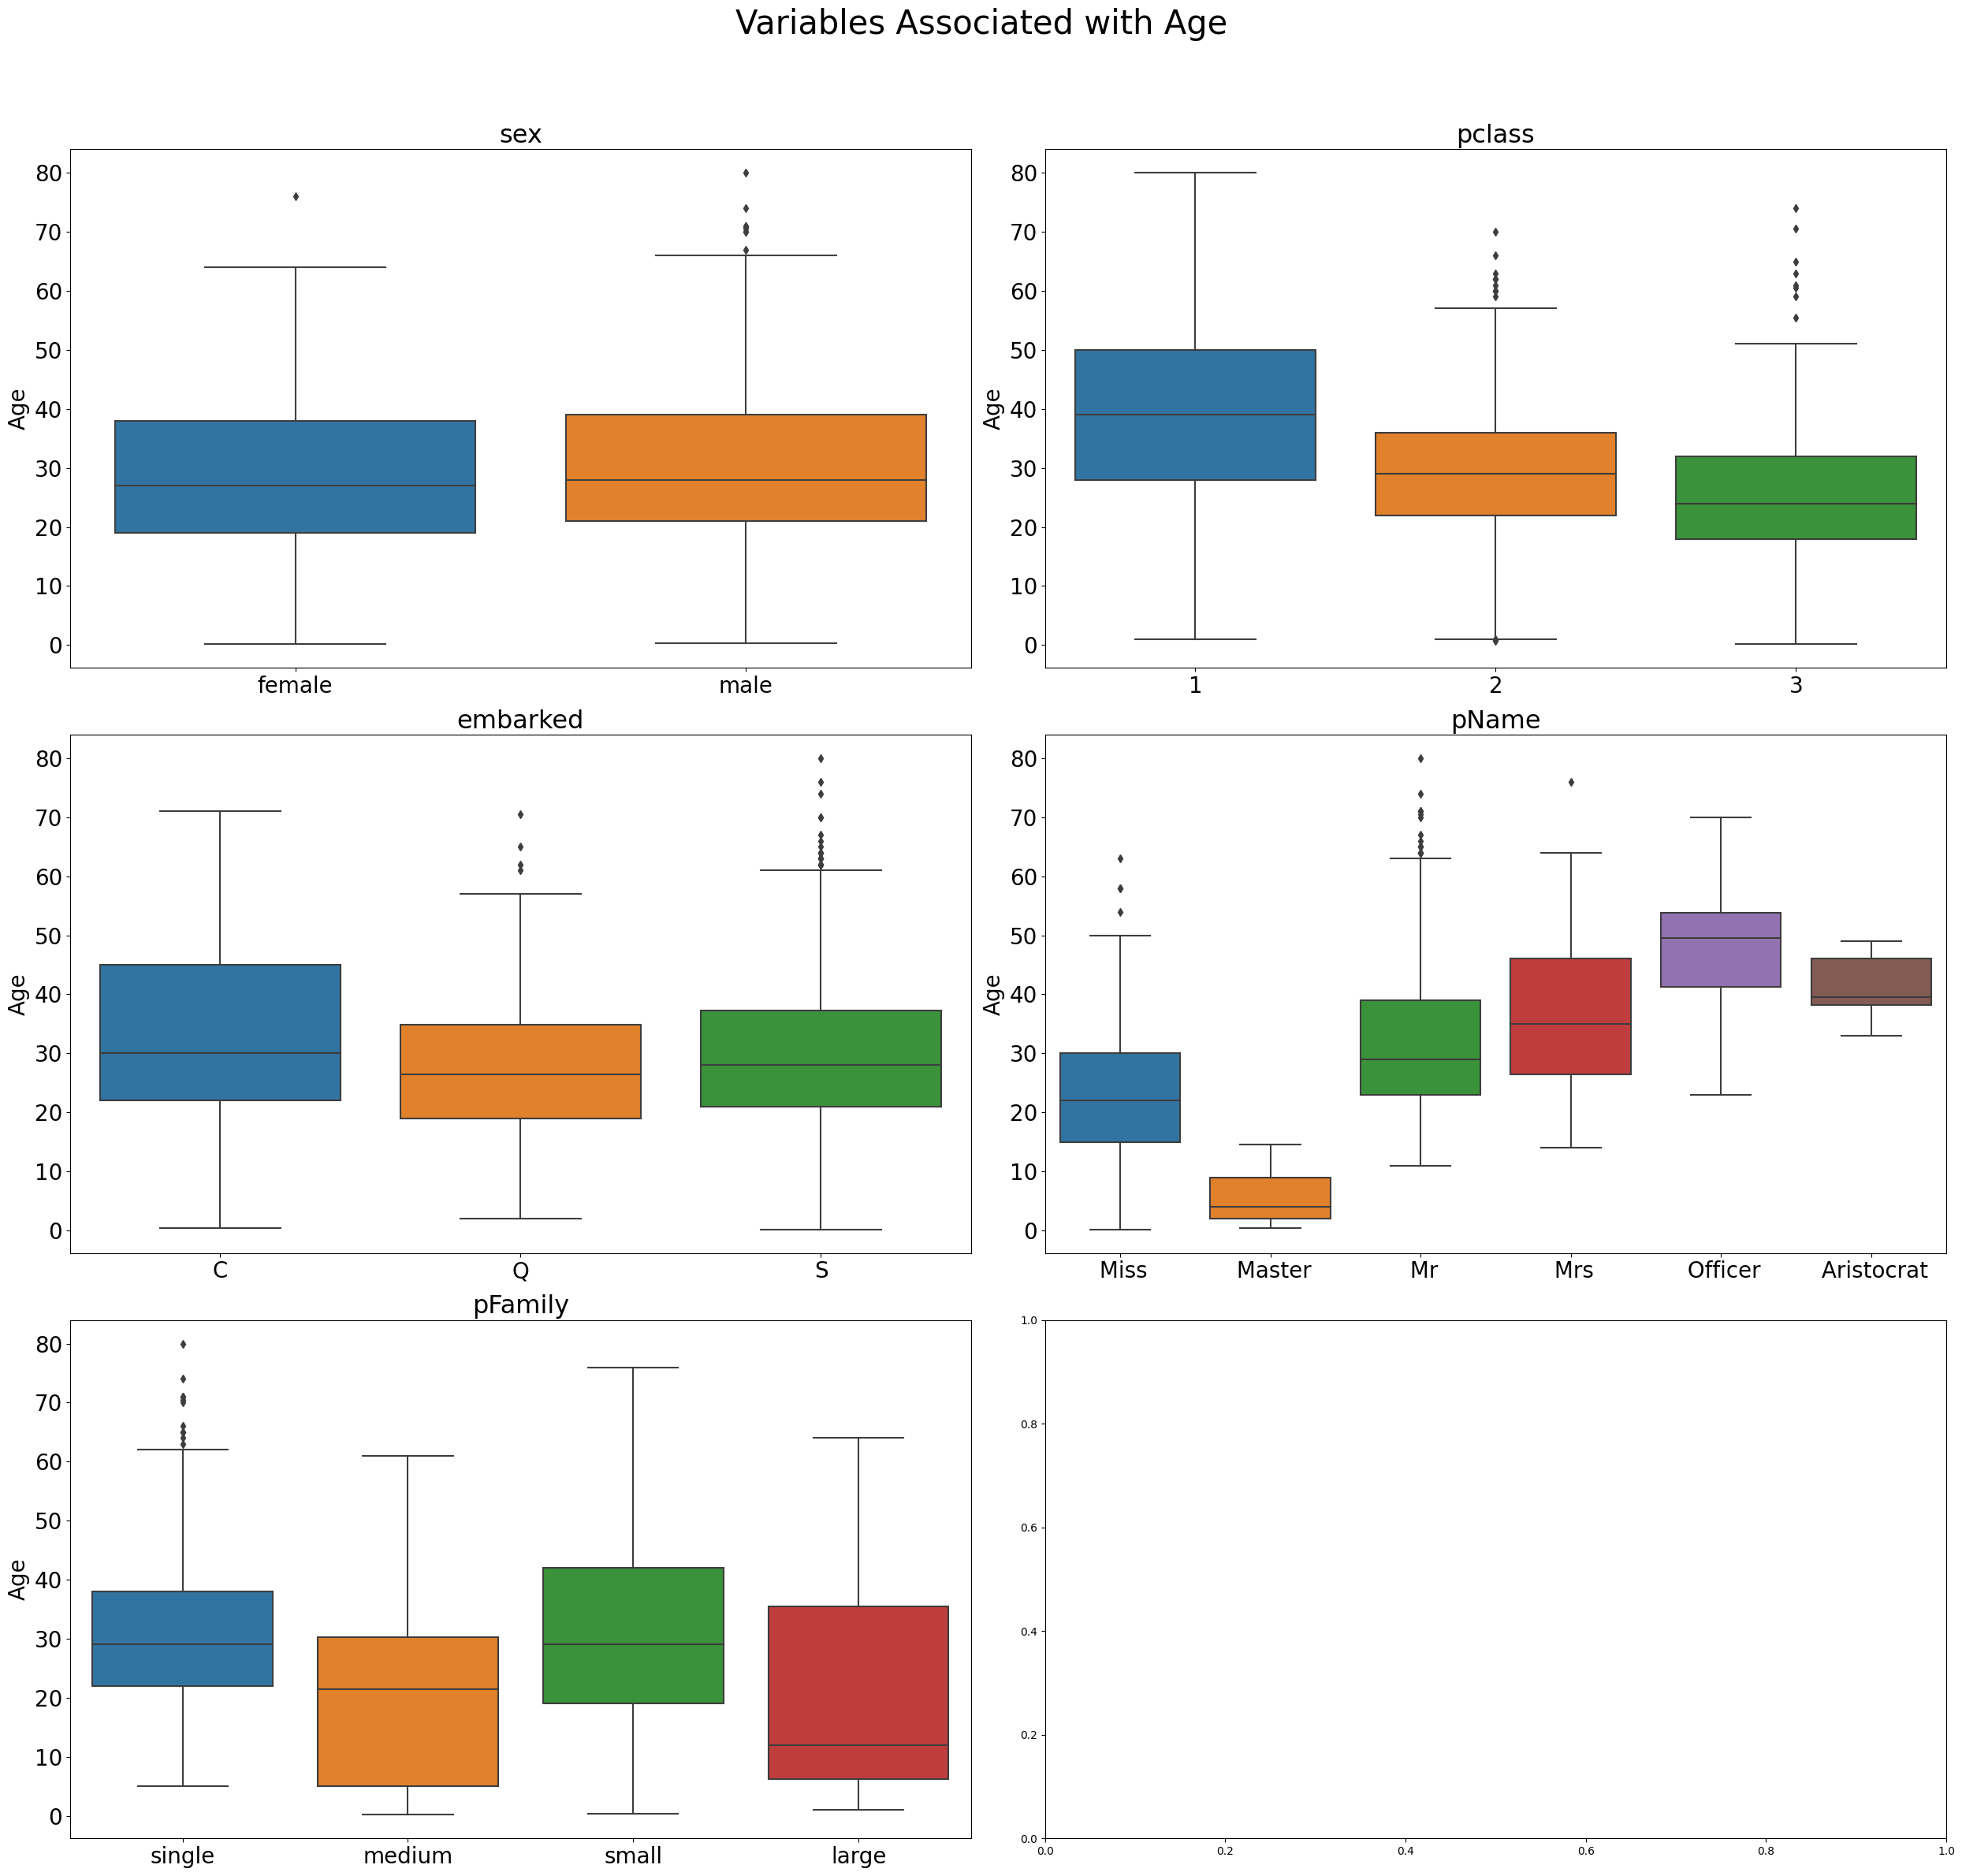

In [51]:
import seaborn as sns
toSearch = df.loc[:, ["sex", "pclass", "embarked", "pName", "pFamily"]]
fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (25,25))
for ax, column in zip(axes.flatten(), toSearch.columns):
    sns.boxplot(x = toSearch[column], y = df.age, ax = ax)
    ax.set_title(column, fontsize = 23)
    ax.tick_params(axis = "both", which = "major", labelsize = 20)
    ax.tick_params(axis = "both", which = "minor", labelsize = 20)
    ax.set_ylabel("Age", fontsize = 20)
    ax.set_xlabel("")
fig.suptitle("Variables Associated with Age", fontsize = 30)
fig.tight_layout(rect = [0, 0.03, 1, 0.95])

1. Age distribution seems to be the same in male and female subpopulations of Sex and S, C, Q subpopulations of Embarked. So Sex and Embarked aren't good predictors for Age.
2. On the other hand, Age distribution seems to be distinct in Pclass's 1, 2 and 3 subpopulations, so Pclass is informative to predict Age.
3. Finally, Age distribution seems to be distinct in different categories for pName, pFamily. So they might be good predictors for Age as well.

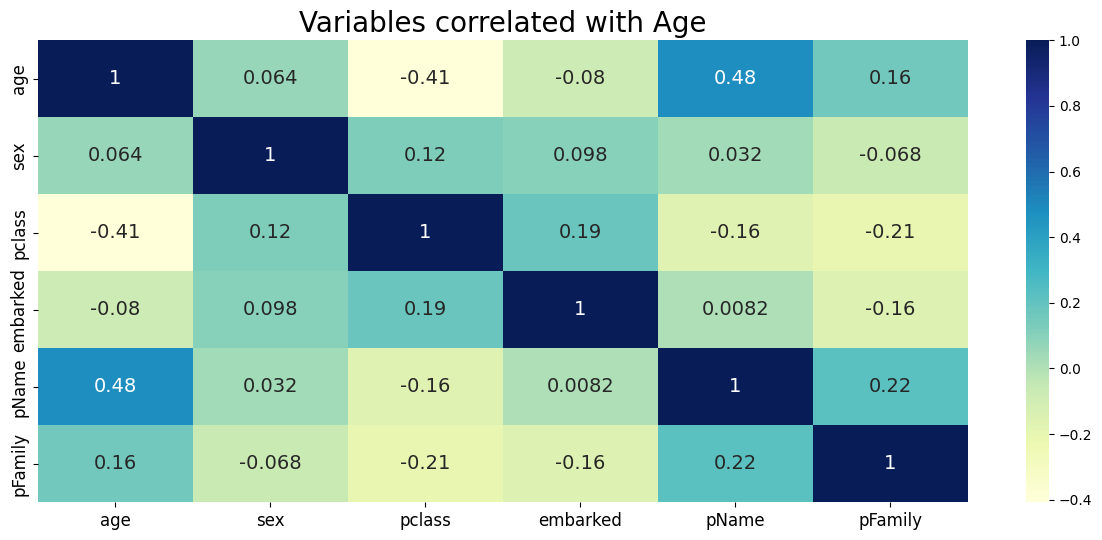

In [52]:
from sklearn.preprocessing import LabelEncoder
toSearch = toSearch.agg(LabelEncoder().fit_transform)
toSearch["age"] = df.age
toSearch = toSearch.set_index("age").reset_index()

fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(15,6))
sns.heatmap(toSearch.corr(), cmap ="YlGnBu", annot=True, annot_kws={"size":14}, ax=ax)
ax.set_title("Variables correlated with Age", fontsize = 20)
ax.tick_params(axis = "both", which = "major", labelsize = 12)
ax.tick_params(axis = "both", which = "minor", labelsize = 12)
plt.show()

In [53]:
df.age = df.groupby(["pName", "pclass"])["age"].transform(lambda x: x.fillna(x.median()))

#### Binning age ####

In [54]:
ageGroups = ["infant","child","adolescents ","adults","oldAdult","elderly"]
groupRanges = [0,1,12,17,35,65,81]
df["ageBinned"] = pd.cut(df.age, groupRanges, labels = ageGroups)

### Process fare ###

In [55]:
df.fare.describe()

count    1309.000000
mean       33.281086
std        51.741500
min         0.000000
25%         7.895800
50%        14.454200
75%        31.275000
max       512.329200
Name: fare, dtype: float64

In [56]:
fareGroups = ["low","medium","high","veryHigh"]
fareGroupRanges = [-1, 130, 260, 390, 520]
df["fareBinned"] = pd.cut(df.fare, fareGroupRanges, labels = fareGroups)

In [57]:
df.isnull().sum()

pclass           0
name             0
sex              0
age              0
sibsp            0
parch            0
ticket           0
fare             0
cabin         1014
embarked         0
boat           823
body          1188
home.dest      564
survived         0
pName            0
pFamily          0
ageBinned        0
fareBinned       0
dtype: int64

## Drop features identification features##

In [58]:
df = df[["pclass", "sex", "embarked", "pName", "pFamily", "ageBinned", "fareBinned", "survived"]]

In [59]:
df

,pclass,sex,embarked,pName,pFamily,ageBinned,fareBinned,survived
0,1,female,S,Miss,single,adults,medium,1
1,1,male,S,Master,medium,infant,medium,1
2,1,female,S,Miss,medium,child,medium,0
3,1,male,S,Mr,medium,adults,medium,0
4,1,female,S,Mrs,medium,adults,medium,0
...,...,...,...,...,...,...,...,...
1304,3,female,C,Miss,small,adolescents,low,0
1305,3,female,C,Miss,small,adults,low,0
1306,3,male,C,Mr,single,adults,low,0
1307,3,male,C,Mr,single,adults,low,0


In [60]:
df.loc[:, ["pclass","pName", "pFamily", "survived"]]= df.loc[:, ["pclass","pName", "pFamily", "survived"]].astype('category')
df.loc[:, ["survived"]]= df.loc[:, ["survived"]].astype('float')

C:\Users\horat\AppData\Local\Temp\ipykernel_15124\1135635640.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\horat\AppData\Local\Temp\ipykernel_15124\1135635640.py:1: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\horat\AppData\Local\Temp\ipykernel_15124\1135635640.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

In [61]:
df.dtypes

pclass        category
sex           category
embarked      category
pName         category
pFamily       category
ageBinned     category
fareBinned    category
survived       float64
dtype: object

## Encoding Variables ##

In [62]:
df = pd.get_dummies(df)

In [63]:
df.shape

(1309, 29)

In [64]:
df

,survived,pclass_1,pclass_2,pclass_3,sex_female,sex_male,embarked_C,embarked_Q,embarked_S,pName_ Aristocrat,pName_ Master,pName_ Miss,pName_ Mr,pName_ Mrs,pName_ Officer,pFamily_large,pFamily_medium,pFamily_single,pFamily_small,ageBinned_infant,ageBinned_child,ageBinned_adolescents,ageBinned_adults,ageBinned_oldAdult,ageBinned_elderly,fareBinned_low,fareBinned_medium,fareBinned_high,fareBinned_veryHigh
0,1.0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0
1,1.0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0
2,0.0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0
3,0.0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0
4,0.0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,0.0,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0
1305,0.0,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0
1306,0.0,0,0,1,0,1,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0
1307,0.0,0,0,1,0,1,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0


## Split dataset ##

In [65]:
X = df.drop('survived', axis=1)
y = df['survived'].astype('category')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 20)

## Feature importance (chi-square test) ##

In [66]:
chi_scores = chi2(X,y)
p_values = pd.Series(chi_scores[1],index = X.columns)
p_values.sort_values(ascending = False , inplace = True)
fig = px.bar(p_values)
fig.update_layout(title_text='P values of all features')
fig.update_xaxes(title_text='Encoded feature')
fig.update_yaxes(title_text='p value')
fig.show()

In [67]:
pvalue_filter = p_values[p_values < 0.05]
selected_features = list(pvalue_filter.index)
selected_features

['pName_ Master',
 'ageBinned_adults',
 'ageBinned_child',
 'fareBinned_veryHigh',
 'pFamily_medium',
 'fareBinned_high',
 'embarked_S',
 'pFamily_large',
 'ageBinned_infant',
 'fareBinned_medium',
 'pFamily_single',
 'embarked_C',
 'pFamily_small',
 'pclass_3',
 'pclass_1',
 'pName_ Miss',
 'sex_male',
 'pName_ Mrs',
 'pName_ Mr',
 'sex_female']

In [68]:
X_train = X_train[selected_features]
X_test = X_test[selected_features]

In [69]:
y_train.value_counts()

0.0    576
1.0    340
Name: survived, dtype: int64

# Random Forest #

In y_train, there are 576 class 0 and 340 class 1, this is an imbalanced dataset. We can designate class weight, which is calculated by total observations / (number of classes * observations in class)

In [70]:
seed = 23
class_weights = {0: 0.793, 1: 1.343}

## Initial Modelling ##

In [71]:
rf = RandomForestClassifier(class_weight=class_weights, random_state=seed)

In [72]:
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 0.793, 1: 1.343}, random_state=23)

The accuracy score is:  0.8438864628820961
The precision score is:  0.797583081570997
The recall score is:  0.7764705882352941
The specificity score is:  0.8836805555555556


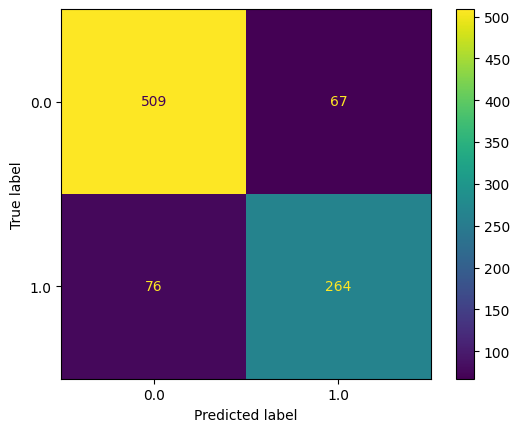

In [73]:
print("The accuracy score is: ", accuracy_score(y_train, rf.predict(X_train)))
print("The precision score is: ", precision_score(y_train, rf.predict(X_train)))
print("The recall score is: ", recall_score(y_train, rf.predict(X_train)))
tn, fp, fn, tp = confusion_matrix(y_train, rf.predict(X_train)).ravel()
specificityScore = tn / (tn + fp)
print("The specificity score is: ", specificityScore)
cm = confusion_matrix(y_train, rf.predict(X_train), labels=rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=rf.classes_)
disp.plot()
plt.show()

The accuracy score is:  0.7938931297709924
The precision score is:  0.7687074829931972
The recall score is:  0.70625
The specificity score is:  0.8540772532188842


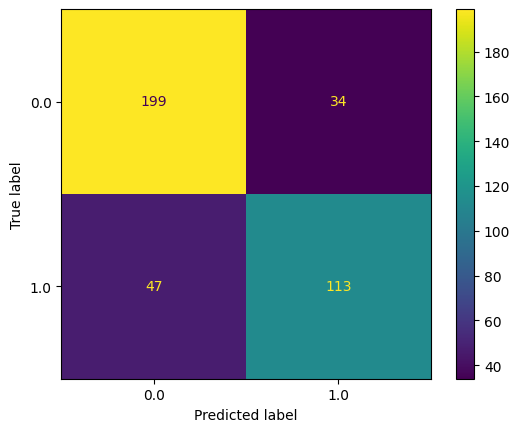

In [74]:
print("The accuracy score is: ", accuracy_score(y_test, rf.predict(X_test)))
print("The precision score is: ", precision_score(y_test, rf.predict(X_test)))
print("The recall score is: ", recall_score(y_test, rf.predict(X_test)))
tn, fp, fn, tp = confusion_matrix(y_test, rf.predict(X_test)).ravel()
specificityScore = tn / (tn + fp)
print("The specificity score is: ", specificityScore)
cm = confusion_matrix(y_test, rf.predict(X_test), labels=rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=rf.classes_)
disp.plot()
plt.show()

## Hyperparamters tuning ##

In [75]:
rfParams = {"criterion":["gini","entropy"],
             "n_estimators":[25, 50, 75, 100, 125, 150],
             "min_samples_leaf":[1, 2, 3],
             "min_samples_split":np.arange(1,6), 
             "max_features":["sqrt", "auto", "log2"],
             "random_state":[seed]}

In [76]:
grid_search = GridSearchCV(estimator = rf, param_grid = rfParams, 
                          cv = 3, n_jobs = -1, verbose = 0, scoring='accuracy')
grid_search.fit(X_train, y_train)

c:\Users\horat\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning:


324 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
324 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\horat\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\horat\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py", line 476, in fit
    trees = Parallel(
  File "c:\Users\horat\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\paralle

GridSearchCV(cv=3,
             estimator=RandomForestClassifier(class_weight={0: 0.793, 1: 1.343},
                                              random_state=23),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': ['sqrt', 'auto', 'log2'],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': array([1, 2, 3, 4, 5]),
                         'n_estimators': [25, 50, 75, 100, 125, 150],
                         'random_state': [23]},
             scoring='accuracy')

In [77]:
best_grid = grid_search.best_estimator_

The accuracy score is:  0.8264192139737991
The precision score is:  0.7623188405797101
The recall score is:  0.7735294117647059
The specificity score is:  0.8576388888888888


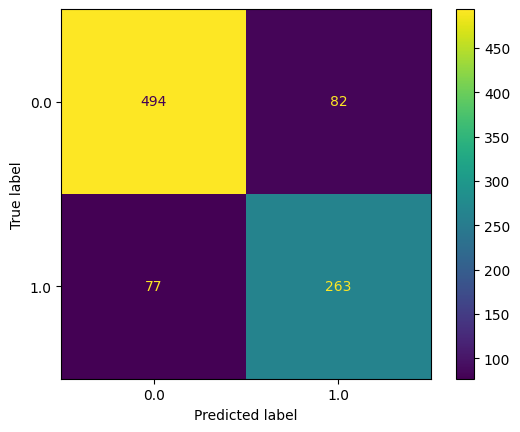

In [78]:
print("The accuracy score is: ", accuracy_score(y_train, best_grid.predict(X_train)))
print("The precision score is: ", precision_score(y_train, best_grid.predict(X_train)))
print("The recall score is: ", recall_score(y_train, best_grid.predict(X_train)))
tn, fp, fn, tp = confusion_matrix(y_train, best_grid.predict(X_train)).ravel()
specificityScore = tn / (tn + fp)
print("The specificity score is: ", specificityScore)
cm = confusion_matrix(y_train, best_grid.predict(X_train), labels=grid_search.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=grid_search.classes_)
disp.plot()
plt.show()

The accuracy score is:  0.8091603053435115
The precision score is:  0.7707006369426752
The recall score is:  0.75625
The specificity score is:  0.8454935622317596


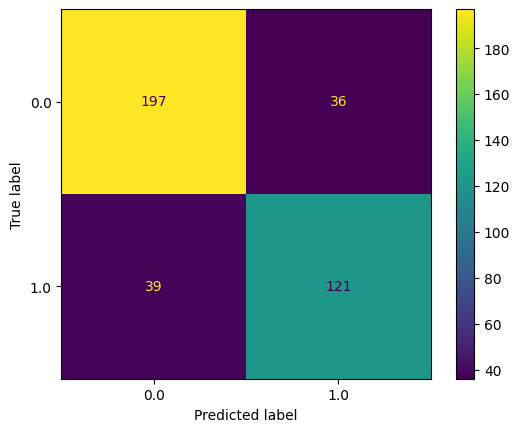

In [79]:
print("The accuracy score is: ", accuracy_score(y_test, best_grid.predict(X_test)))
print("The precision score is: ", precision_score(y_test, best_grid.predict(X_test)))
print("The recall score is: ", recall_score(y_test, best_grid.predict(X_test)))
tn, fp, fn, tp = confusion_matrix(y_test, best_grid.predict(X_test)).ravel()
specificityScore = tn / (tn + fp)
print("The specificity score is: ", specificityScore)
cm = confusion_matrix(y_test, best_grid.predict(X_test), labels=grid_search.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=grid_search.classes_)
disp.plot()
plt.show()

In [80]:
print(f"Execution time: {time.time() - start_time}")

Execution time: 84.56155753135681
